In [1]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = get_dax_data()

In [3]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [4]:
df_cval.tail()

,Close,ret1,ret2,ret3,ret4,ret5
2023-11-29,16166.450195,1.080763,1.245348,0.850795,1.067880,1.298911
2023-11-30,16215.429688,0.302512,1.383275,1.547860,1.153307,1.370392
2023-12-01,16397.519531,1.116684,1.419196,2.499959,2.664543,2.269991
2023-12-04,16404.759766,0.044145,1.160828,1.463340,2.544103,2.708688
2023-12-05,16533.109375,0.779348,0.823492,1.940176,2.242688,3.323451


In [5]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before, target='DAX')
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [8]:
from DAX.Models.arma_garch_11 import arma_garch_11
from DAX.Models.garch11 import garch11, garch11_t
from DAX.Models.baseline_100 import baseline_100
from DAX.Models.baseline_300 import baseline_300

models = [
    {
        'name': 'baseline',
        'function': baseline
    },
    {
        'name': 'garch11_t',
        'function': garch11_t
    },
    {
        'name': 'arma_garch_11',
        'function': arma_garch_11
    },
    {
        'name': 'baseline_armagarch11',
        'function': [[baseline, arma_garch_11],[0.5,0.5]]
     },
    # {
    #     'name': 'baseline_300',
    #     'function': baseline_300
    #  },
    # {
    #     'name': 'baseline_100',
    #     'function': baseline_100
    #  },
]


In [9]:
evaluate_models(models, df, 20, weeks=True)

*********** Start the evaluation of Model baseline ***********
Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20
*********** Start the evaluation of Model garch11_t ***********
Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20
*********** Start the evaluation of Model arma_garch_11 ***********
Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration

In [18]:
with open('./Model evaluations/ARMAGARCH11.pkl', 'wb') as f:
    pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [11]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)
score_df = score_df.sort_index()

In [12]:
score_df

,baseline: 1 day,garch11_t: 1 day,arma_garch_11: 1 day,baseline_armagarch11: 1 day,baseline: 2 day,garch11_t: 2 day,arma_garch_11: 2 day,baseline_armagarch11: 2 day,baseline: 5 day,garch11_t: 5 day,arma_garch_11: 5 day,baseline_armagarch11: 5 day,baseline: 6 day,garch11_t: 6 day,arma_garch_11: 6 day,baseline_armagarch11: 6 day,baseline: 7 day,garch11_t: 7 day,arma_garch_11: 7 day,baseline_armagarch11: 7 day
forecast_date,,,,,,,,,,,,,,,,,,,,
2023-07-26,1.49893,1.259728,1.73177,1.61535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-27,NaN,NaN,NaN,NaN,2.713676,3.080077,2.562895,2.638285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.566403,4.073871,3.556327,3.561365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.988553,3.388976,2.903646,2.9461,NaN,NaN,NaN,NaN
2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.196824,2.385761,2.146533,2.171678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-06,1.653543,1.853287,1.856951,1.73293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-07,NaN,NaN,NaN,NaN,1.779566,1.788916,1.591088,1.685327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.969284,3.446613,2.377554,2.570677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot obtained scores

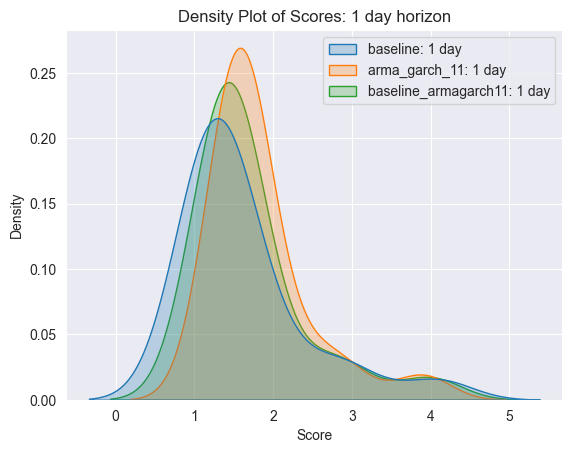

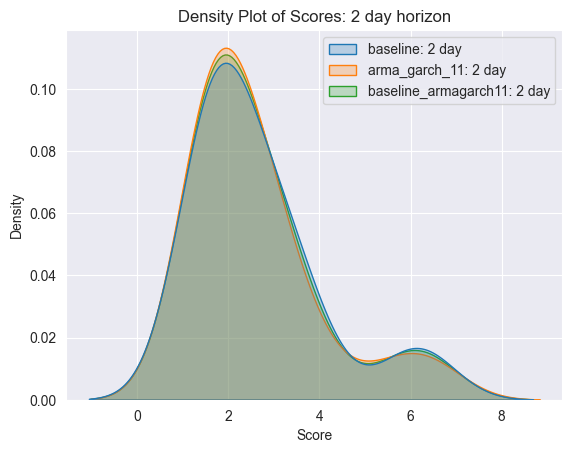

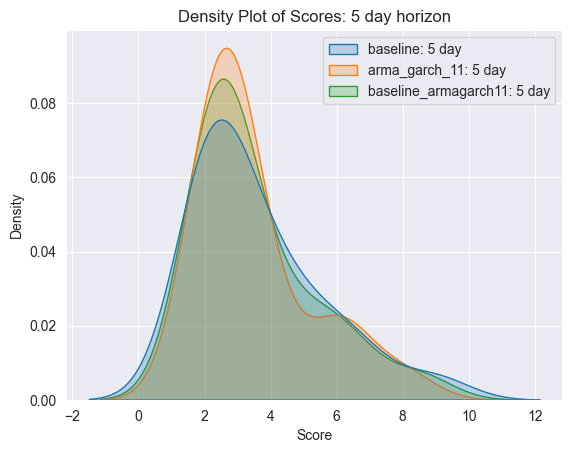

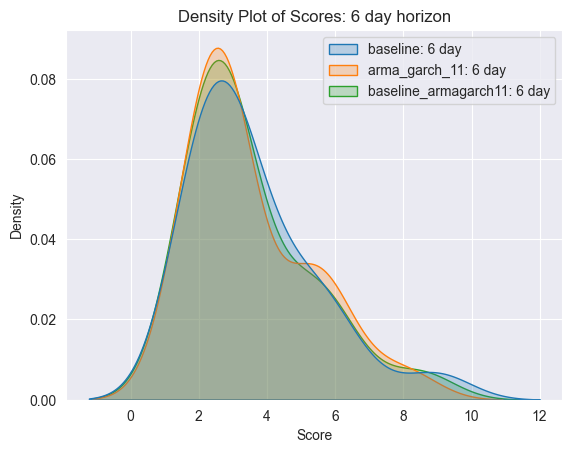

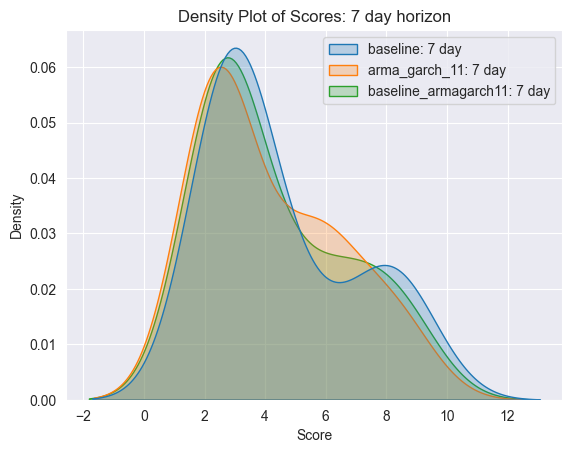

In [16]:
# models_display = ['baseline','garch11_t', 'arma_garch_11', 'baseline_armagarch11']
models_display = ['baseline', 'arma_garch_11', 'baseline_armagarch11']
# models_display = ['baseline', 'model4_sunhours', 'model4_holidays_2', 'model4', 'model4_population']
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    # sns.kdeplot(data=score_df.loc[:,[f'baseline: {h}',f'model3: {h}',f'MM_baseline_model3: {h}']], fill=True)
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.savefig(f'../Plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()

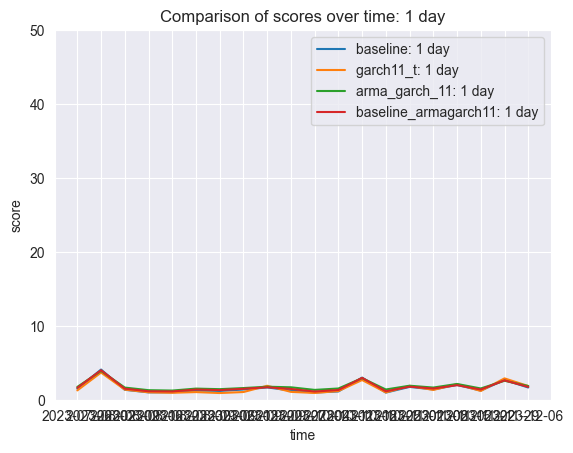

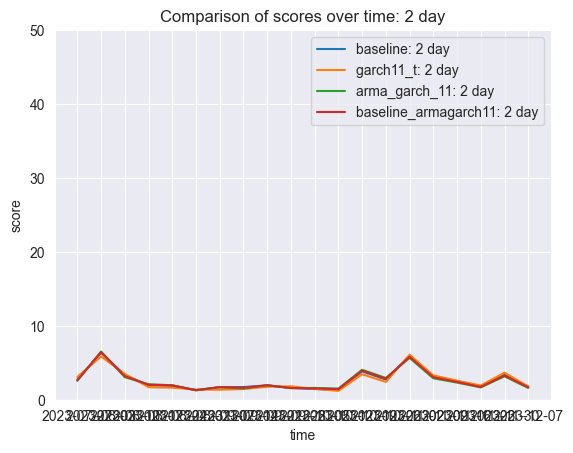

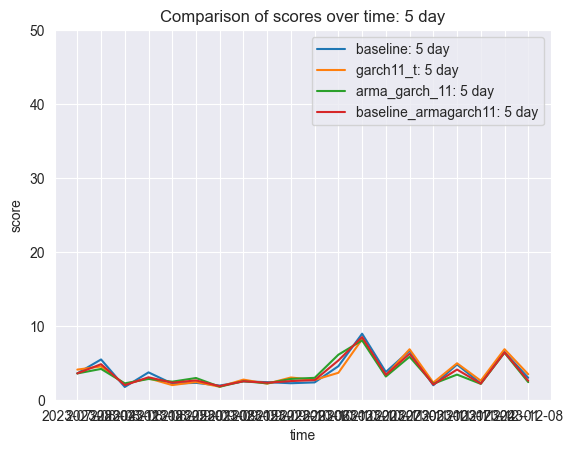

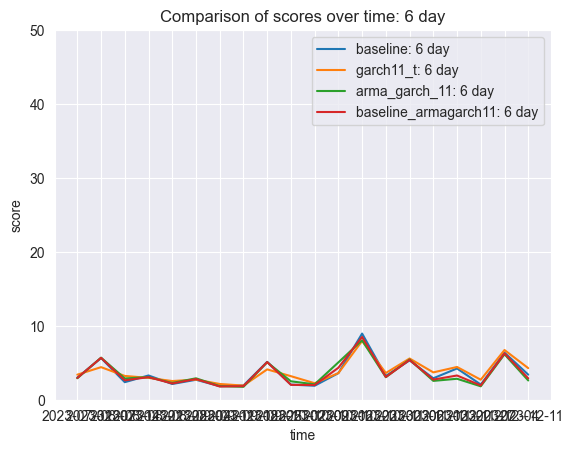

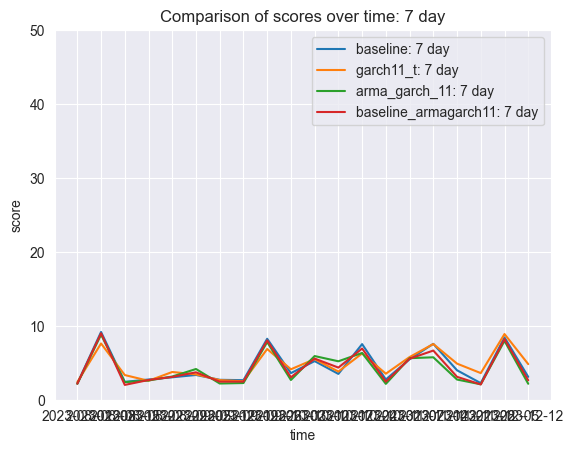

In [14]:
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)

    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.savefig(f'../Plots/line_plot_{h.replace(" ", "_")}.png')

    # Show the plot
    plt.show()